In [2]:
%matplotlib inline

import imageio
import scipy.stats
import scipy.special

import numpy as np
import pandas as pd
from numpy import array as arr

import os
import re
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
from astropy.io import fits

from scipy.stats import sem 
from scipy import ndimage as ndi
from scipy.optimize import curve_fit

import sys
sys.path.append('../../Analysis_code/klab_python_lib/')

import klib

### Can comment below if not editing klib
%load_ext autoreload
%aimport klib
%autoreload

In [23]:
from typing import Optional
import cv2
from pymba import Vimba, VimbaException, Frame
import time

# todo add more colours
PIXEL_FORMATS_CONVERSIONS = {
    'BayerRG8': cv2.COLOR_BAYER_RG2RGB,
}


def display_frame(frame: Frame, delay: Optional[int] = 1) -> None:
    """
    Displays the acquired frame.
    :param frame: The frame object to display.
    :param delay: Display delay in milliseconds, use 0 for indefinite.
    """
    print('frame {}'.format(frame.data.frameID))

    # get a copy of the frame data
    image = frame.buffer_data_numpy()

    plt.imshow(image)
    plt.show()
#     # convert colour space if desired
#     try:
#         image = cv2.cvtColor(image, PIXEL_FORMATS_CONVERSIONS[frame.pixel_format])
#     except KeyError:
#         pass

#     # display image
#     cv2.imshow('Image', image)
#     cv2.waitKey(delay)

def print_camera_options(cameraID):
    with Vimba() as vimba:
        camera = vimba.camera(cameraID)
        camera.open()

        # get feature value via feature object
        for feature_name in camera.feature_names():
            feature = camera.feature(feature_name)

            try:
                value = feature.value
                range_ = feature.range

                # alternatively the feature value can be read as an object attribute
                # value = getattr(camera, feature_name)
                # or
                # value = camera.someFeatureName

            except VimbaException as e:
                value = e
                range_ = None

            print('\n\t'.join(
                str(x) for x in (
                    feature_name,
                    'value: {}'.format(value),
                    'range: {}'.format(range_))
                if x is not None))

        camera.close()
    
def print_ids():
    with Vimba() as vimba:
        print(vimba.camera_ids())
        
def capture_image(cameraID):
    with Vimba() as vimba:
        camera = vimba.camera(cameraID)
        camera.open()

        camera.feature('TriggerSource').value = 'Software'
        camera.feature('TriggerSelector').value = 'FrameStart'
        camera.feature('AcquisitionFrameRateMode').value = 'Off'
        camera.feature('ExposureMode').value = 'Timed'
        camera.feature('ExposureTime').value = 100
        camera.feature('TriggerMode').value = 'Off'

        camera.arm('SingleFrame')
        # capture a single frame, more than once if desired
        for i in range(1):
            try:
                frame = camera.acquire_frame()
            except VimbaException as e:
                # rearm camera upon frame timeout
                if e.error_code == VimbaException.ERR_TIMEOUT:
                    print(e)
                    camera.disarm()
                    camera.arm('SingleFrame')
                else:
                    raise
        image = frame.buffer_data_numpy()
        camera.disarm()
        camera.close()
        np.savetxt('tmp_img.txt', image, fmt='%d')
#         plt.imshow(image)

In [4]:
print_ids()
# print_camera_options()

['DEV_1AB228000566', 'DEV_1AB2280005BE', 'DEV_1AB2280006D0']


Peaks found:2


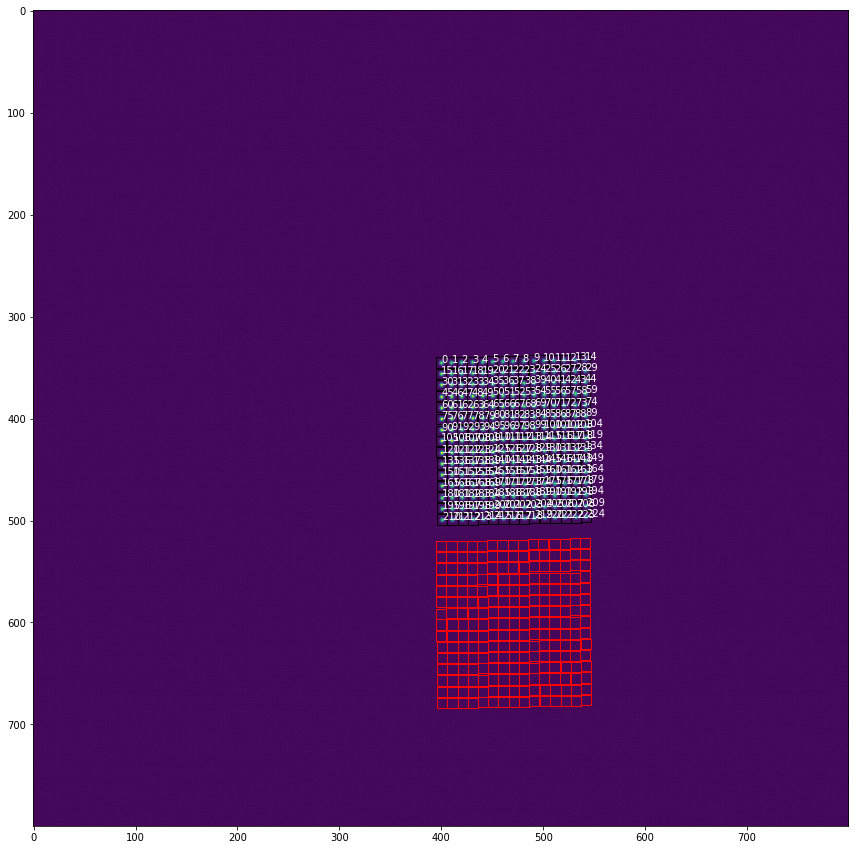

Peaks found:225


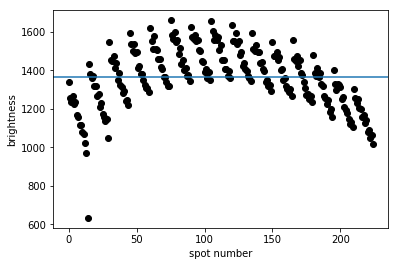

Mean val: 1363.01333333


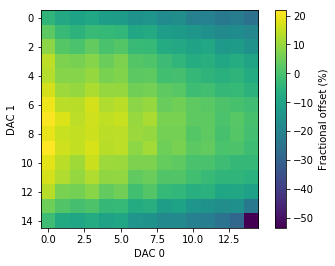

In [30]:
# %autoreload
capture_image(cameraID = 2)
img = np.loadtxt('tmp_img.txt', dtype=int);

N=15

bigRoiSettings = [400, 200, 40]
roiSettings = [5, 15, 30]
bgoff = (0,180)
bigRoi = klib.analysis.find_rois(img, *bigRoiSettings, bgoff, display = False)[0][0]
img = img[bigRoi[2]:bigRoi[3],bigRoi[0]:bigRoi[1]]

rois, bgrois = klib.analysis.find_rois(img, *roiSettings, bgoff)

roisums = np.array(list(map(lambda roi: klib.analysis.get_roi_sum(img, roi, bgoff, display=False, bgsub = True),rois)))

# roi = rois[0]
# iimg = img[roi[2]:roi[3],roi[0]:roi[1]]

# fitdat, params, perr = klib.mathutil.gaussianBeamFit2D(iimg)
# plt.imshow(iimg)
# plt.contour(fitdat)
# plt.show()

plt.plot(roisums, 'ko')
# plt.axis([-.1, 11.1, 0, 1.1*max(roisums)])
plt.xlabel('spot number')
plt.ylabel('brightness')
plt.axhline(y=np.mean(roisums))
plt.show()
print('Mean val:', np.mean(roisums))

plt.imshow((roisums.reshape((N,N))[::-1,:]-roisums.mean())/roisums.mean()*100)
plt.xlabel("DAC 0")
plt.ylabel("DAC 1")
cbar = plt.colorbar()
cbar.set_label('Fractional offset (%)')
plt.show()

In [6]:
# Starting point for generating tones

numtones = 3
freqcenter = 185
spacing = 15
amp_guess = 95

# if len(roisums) > numtones:
#     roisums = roisums[::2]

tone_inds = np.arange(numtones)
freqs = np.arange(freqcenter-spacing*numtones/2, freqcenter+spacing*numtones/2, spacing)
phases = np.pi*((tone_inds+1)**2)/(numtones)
phase_degs = np.round(phases*180/np.pi%360, 1)

ampscale = .01

old_amps = np.ones(numtones)*amp_guess
new_amps = old_amps

for ind in tone_inds:
    print('set', "DAC0", ind, new_amps[ind], freqs[ind], phase_degs[ind])

print()
    
for ind in tone_inds:
    print('set', "DAC1", ind, new_amps[ind], freqs[ind], phase_degs[ind])

set DAC0 0 95.0 162.5 60.0
set DAC0 1 95.0 177.5 240.0
set DAC0 2 95.0 192.5 180.0

set DAC1 0 95.0 162.5 60.0
set DAC1 1 95.0 177.5 240.0
set DAC1 2 95.0 192.5 180.0


In [140]:
roisumss = np.mean(roisums.reshape((9,9)), axis = 0)  #DAC0
# roisumss = roisums.reshape((9,9))[4,:]  #DAC0
dac = 'DAC0'

# roisumss = np.mean(roisums.reshape((9,9))[::-1,:], axis = 1)  #DAC1
# # roisumss = roisums.reshape((9,9))[::-1,4]  #DAC1
# dac = 'DAC1'

old_amps = new_amps
new_amps = old_amps - (roisumss-np.mean(roisumss))*ampscale

for ind in tone_inds:
    print('set', dac, ind, new_amps[ind], freqs[ind], phase_degs[ind])

set DAC0 0 88.0396296296 149.0 20.0
set DAC0 1 82.7051851852 157.0 80.0
set DAC0 2 84.4307407407 165.0 180.0
set DAC0 3 81.252962963 173.0 320.0
set DAC0 4 84.7707407407 181.0 140.0
set DAC0 5 79.9251851852 189.0 0.0
set DAC0 6 82.972962963 197.0 260.0
set DAC0 7 84.4874074074 205.0 200.0
set DAC0 8 96.4151851852 213.0 180.0


In [112]:
temp_amps = new_amps

In [129]:
old_amps = temp_amps

In [ ]:
plt.imshow((roisums.reshape((1,5))-roisums.mean())/roisums.mean()*100)

In [101]:
roisums.reshape((5,5))[0,:], roisums.reshape((5,5))[:,0]

(array([1246, 1019,  878, 1345, 1105]), array([1246, 2987, 2281, 2429, 1856]))

In [246]:
a = np.arange(10)
a = a[::-1]
a

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])